In [194]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from scipy.integrate import solve_ivp


hr2s = 1/3600
wm = 0.5 * hr2s
wd = 0.05 * hr2s

loss_diatoms = 0.006 * hr2s
loss_mc  = 0.004 * hr2s

def create_range_over(number, mult, N):
    return np.linspace(number*(1/mult), number*mult, N)

mult = 10 
N = 4


# Loss 
loss_diatoms = create_range_over(0.006 * hr2s, mult, 2)
loss_microcystis = create_range_over(0.004 * hr2s, mult, 2)
print(loss_microcystis) 

# Swimming / sinking 
velocity_diatoms = create_range_over(wd, mult, N)
velocity_microcystis = create_range_over(wm, mult, N)

# Growth
growth_diatoms = create_range_over(0.05*hr2s, mult, N)
growth_microcystis = create_range_over(0.008*hr2s, mult, N)

# Diffusivity 
kappa = np.logspace(-2, -9, N, base=10)

# Ratio between depths
depth_ratio = np.linspace(0.1, 1, N)
total_depth = np.linspace(1, 10, N)


# Create mesh grid across all parameters
Ld, Lm, Growth_Diatoms, Growth_MC, Kappa, R, H = np.meshgrid(loss_diatoms, loss_microcystis, growth_diatoms, growth_microcystis, kappa, depth_ratio, total_depth) 

print("Parameter grid shape:", Ld.shape)  # Print the shape of the last grid

results_m = np.zeros(Ld.shape)
results_d = np.zeros(Ld.shape)
SHAPE = Ld.shape

[1.11111111e-07 1.11111111e-05]
Parameter grid shape: (2, 2, 4, 4, 4, 4, 4)


In [195]:

# Get list of all the indices in this grid

T = 3600 * 5


all_indices = list(np.ndindex(*SHAPE))
print(len(all_indices))

for (i, j, k, l, m, n, o) in all_indices:

    ld = Ld[i, j, k, l, m, n, o]
    lm = Lm[i, j, k, l, m, n, o]
    growth_d = Growth_Diatoms[i, j, k, l, m, n, o]
    growth_m = Growth_MC[i, j, k, l, m, n, o]
    kappa = Kappa[i, j, k, l, m, n, o]
    r = R[i, j, k, l, m, n, o]
    h = H[i, j, k, l, m, n, o]
    h2 = h/(1 + r)
    h1 = r*h2 
    
    def system(t, vars):
        m1, m2, d1, d2, n1, n2 = vars
        dm1dt = 1/h1 *wm*m2 + kappa/h1 * (m2 - m1) - lm*m1  + growth_m  * n1 #n1/(sensitivity + n1)  #+ growth_m * n1*m1 
        dm2dt = -1/h2 * wm*m2 + kappa/h2*(m1-m2) - lm*m2

        d1dt = -1/h1 * wd * d1 + kappa/h1 * (d2 - d1) - ld*d1 + growth_d * n1 #n1/(sensitivity + n1) #+ growth_d*n1*d1 
        d2dt = 1/h2*wd*d1 + kappa/h1 * (d1-d1)  - ld*d2
        
        dn1dt = kappa/h1 * (n2 - n1) - growth_m  * n1*m1  - growth_d  * n1*d1
        dn2dt = kappa/h2 * (n1 - n2)
        return [dm1dt, dm2dt, d1dt, d2dt, dn1dt, dn2dt]

    sol = solve_ivp(system, 
                        t_span = [0,T],
                        y0=[1*h1, 1*h2, 1*h1, 1*h2, 1*h1,1*h2],
                        t_eval=np.linspace(0,T,10),
                        rtol=1e-8, atol=1e-8)

    m1 = sol.y[0,:].T[-1] 
    m2 = sol.y[1,:].T[-1]
    d1 = sol.y[2,:].T[-1]
    d2 = sol.y[3,:].T[-1]

    results_m[i, j, k, l, m, n, o] = m1 + m2 
    results_d[i, j, k, l, m, n, o] = d1 + d2 


4096


In [74]:
diff_m = (results_m - H)/H
diff_d = (results_d - H)/H



Depth =  1.0
Depth =  4.0
Depth =  7.0
Depth =  10.0


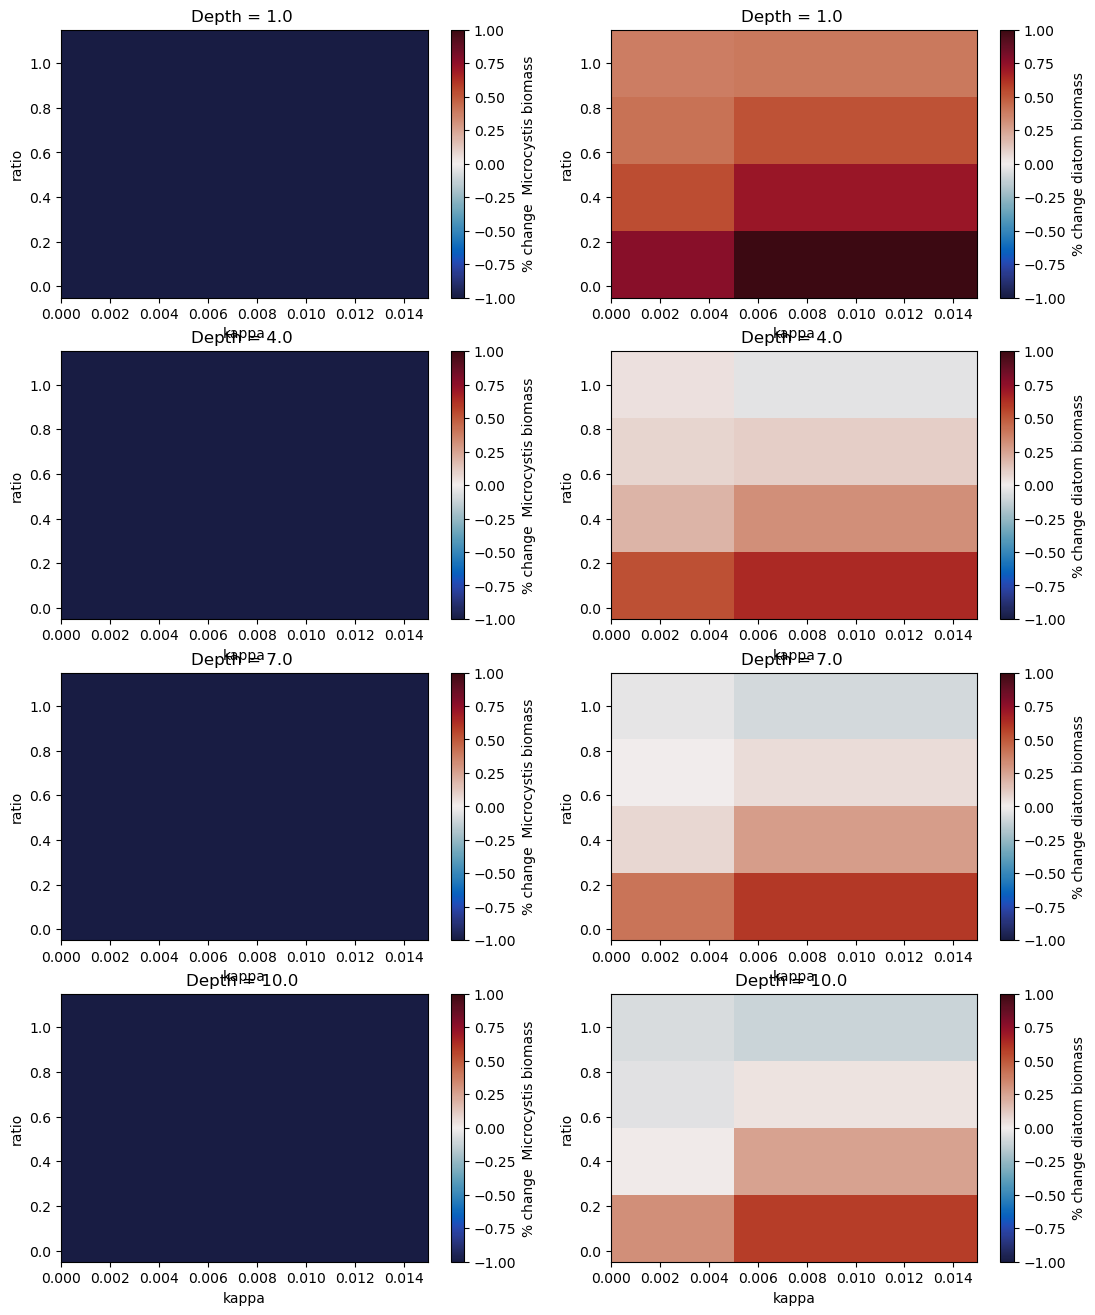

In [84]:
def reshape_(data, N):
    return np.array(data).reshape(N, -1)

# Define norm 
import matplotlib.colors as mcolors
import cmocean as cmo

# 0 : loss_diatoms
# 1 : loss_microcystis,  growth_microcystis, kappa, depth_ratio, total_depth
# 2 : growth_diatoms
# 3 : growth_microcystis
# 4 : kappa
# 5: depth_ratio
# 6 : total_depth

plt.close()


fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(13, 16))
axs = axs.flatten()
cmap = cmo.cm.balance
norm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
N = Ld.shape[0]  # Assuming Ld is a 3D array, we take the first dimension as N

for i in range(0,N): 
    
    idx = (2,2,2,0,slice(None),slice(None),i)

    labelx = "kappa" #"Diffusivity" 
    labely=  "ratio" #"Ratio (h1/h2)"

    X = Kappa[idx]
    Y = R[idx]

    diff_d0 = diff_d[idx]
    diff_m0 = diff_m[idx]

    print("Depth = ", H[0,0,0,0,0,0,i])
    x = reshape_(X, N)
    y = reshape_(Y, N)

    h = axs[2*i].pcolormesh(x, y, reshape_(diff_m0, N),
                cmap=cmap, shading='auto', norm =norm)
    plt.colorbar(h, ax=axs[2*i], label=r"% change  Microcystis biomass")

    h = axs[i*2+1].pcolormesh(x, y, reshape_(diff_d0, N),
                cmap=cmap, shading='auto', norm=norm)
    
    plt.colorbar(h, ax=axs[i*2+1], label=r"% change diatom biomass")

    axs[i*2].set_title("Depth = %2.1f "% H[0,0,0,0,0,0,i])
    axs[i*2+1].set_title("Depth = %2.1f "% H[0,0,0,0,0,0,i])

for ax in axs:
    ax.set_xlabel(labelx)
    ax.set_ylabel(labely)


In [ ]:
idx = [slice(None),slice(None),slice(None),slice(None),slice(None),slice(None),slice(None)]

idx[0] = 2

print(np.unique(Ld[tuple(idx)]))

# Ld / 1 
# Lm / 0 
# R / 5 

[2, slice(None, None, None), slice(None, None, None), slice(None, None, None), slice(None, None, None), slice(None, None, None), slice(None, None, None)]
[1.38888889e-07 4.72222222e-06 9.30555556e-06 1.38888889e-05]


loss_microcystis
[1.66666667e-07 1.66666667e-05]


ValueError: x and y must have same first dimension, but have shapes (2048,) and (4096,)

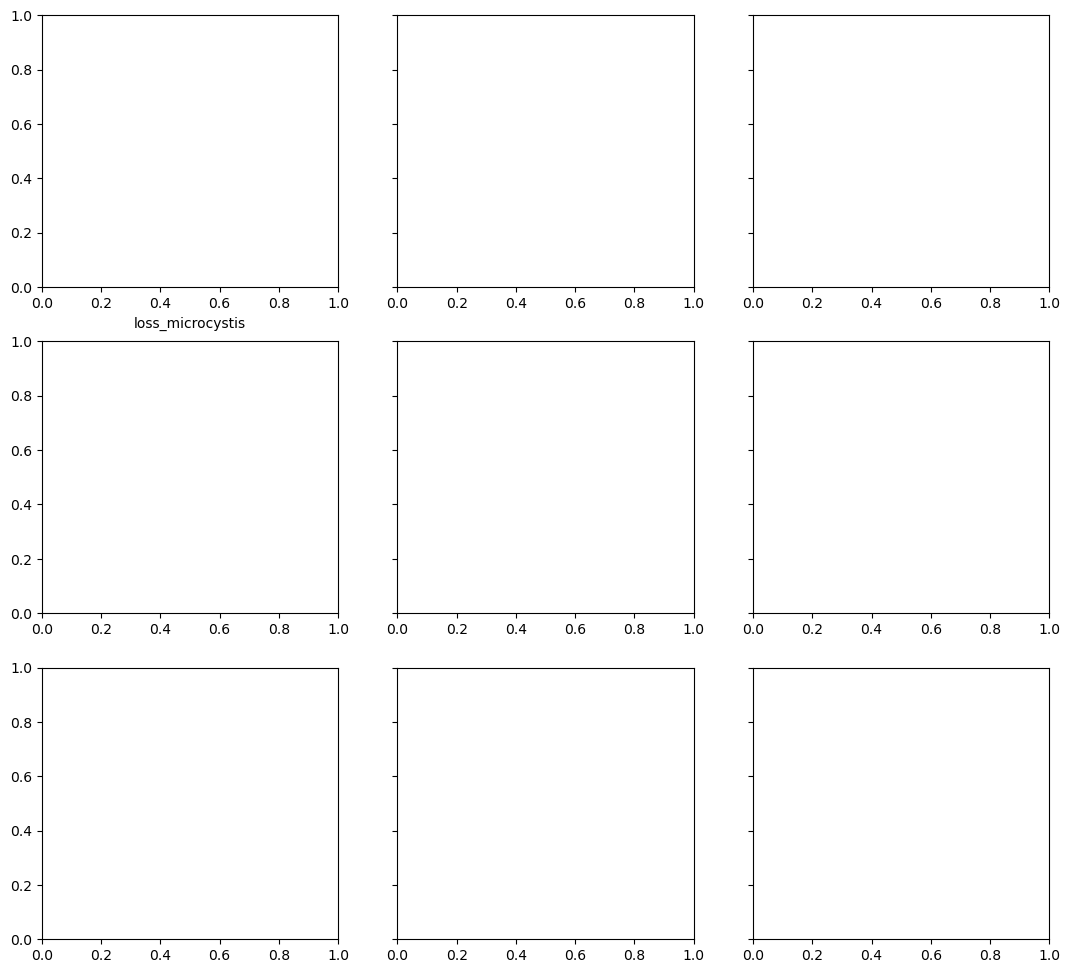

In [196]:

# 0 : loss_diatoms
# 1 : loss_microcystis,  growth_microcystis, kappa, depth_ratio, total_depth
# 2 : growth_diatoms
# 3 : growth_microcystis
# 4 : kappa
# 5: depth_ratio
# 6 : total_depth
var_names = ["loss_microcystis","loss_diatoms",  "growth_diatoms", "growth_microcystis", "kappa", "depth_ratio", "total_depth"]
gridded_vars = [Ld, Lm, Growth_Diatoms, Growth_MC, Kappa, R, H]
idx = [slice(None),slice(None),slice(None),slice(None),slice(None),slice(None),slice(None)]

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(13, 12), sharey=True)
axs = axs.flatten()
for j in range(0,7):
    print(var_names[j])
    # axs[j].set_title(var_names[j])
    axs[j].set_xlabel(var_names[j])
    for i in range(0,N): 
        idx0 = idx.copy()
        idx0[j] = i


        X = gridded_vars[j][tuple(idx0)]

        diff_d0 = diff_d[tuple(idx0)]
        diff_m0 = diff_m[tuple(idx0)]
        # print(X.flatten())
        print(np.unique(X))
        axs[j].plot(X.flatten(), diff_d0.flatten(), '^', color="#348888")
        axs[j].plot(X.flatten(), diff_m0.flatten(), '.', color="#FA7F08", alpha=0.26)

    
    
axs[4].set_xscale('log')

for ax in axs[0:7]:
    ax.grid(alpha=0.5)
    ax.plot([], [], '^', color="#348888", label="Diatoms")
    ax.plot([], [], '.', color="#FA7F08", alpha=0.9, label="Microcystis")
    ax.legend()
    
# turn off last two axes
axs[7].axis('off')
axs[8].axis('off')


loss_microcystis
[1.11111111e-07]
[3.77777778e-06]
[7.44444444e-06]
[1.11111111e-05]
loss_diatoms
[1.66666667e-07]
[5.66666667e-06]
[1.11666667e-05]
[1.66666667e-05]
growth_diatoms
[1.38888889e-06]
[4.72222222e-05]
[9.30555556e-05]
[0.00013889]
growth_microcystis
[2.22222222e-07]
[7.55555556e-06]
[1.48888889e-05]
[2.22222222e-05]
kappa
[0.01]
[4.64158883e-05]
[2.15443469e-07]
[1.e-09]
depth_ratio
[0.1]
[0.4]
[0.7]
[1.]
total_depth
[1.]
[4.]
[7.]
[10.]


(np.float64(0.0), np.float64(1.0), np.float64(-182.15), np.float64(3825.15))

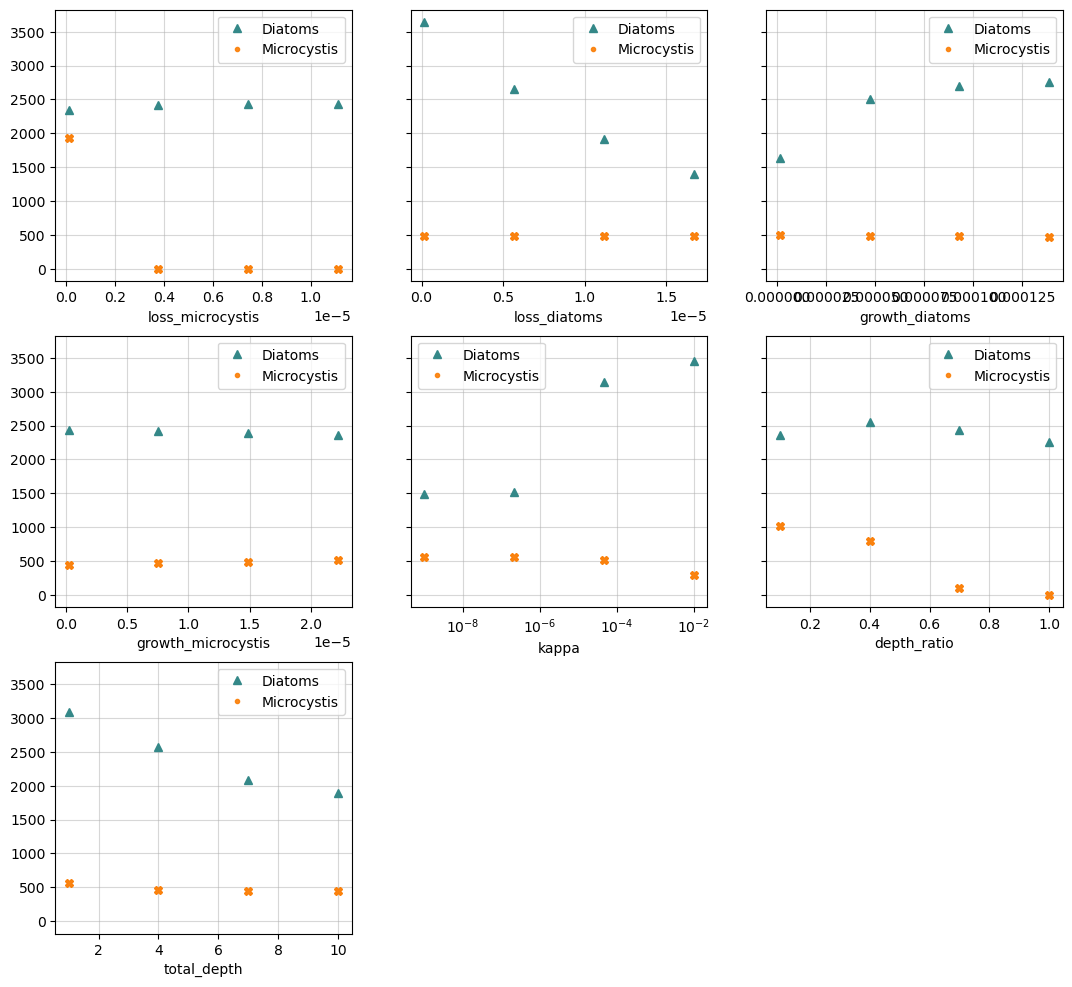

In [193]:

# 0 : loss_diatoms
# 1 : loss_microcystis,  growth_microcystis, kappa, depth_ratio, total_depth
# 2 : growth_diatoms
# 3 : growth_microcystis
# 4 : kappa
# 5: depth_ratio
# 6 : total_depth
var_names = ["loss_microcystis", "loss_diatoms", "growth_diatoms", "growth_microcystis", "kappa", "depth_ratio", "total_depth"]
gridded_vars = [Lm, Ld,  Growth_Diatoms, Growth_MC, Kappa, R, H]
idx = [slice(None),slice(None),slice(None),slice(None),slice(None),slice(None),slice(None)]

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(13, 12), sharey=True)
axs = axs.flatten()
for j in range(0,7):
    print(var_names[j])
    # axs[j].set_title(var_names[j])
    axs[j].set_xlabel(var_names[j])
    for i in range(0,N): 
        idx0 = idx.copy()
        idx0[j] = i


        X = gridded_vars[j][tuple(idx0)]

        diff_d0 = diff_d[tuple(idx0)]
        diff_m0 = diff_m[tuple(idx0)]
        diff_d0 = np.sum(diff_d0>0.0) 
        diff_m0 = np.sum(diff_m0>0.0)

        X = np.unique(X)
        print(X)
        axs[j].plot(X, diff_d0.flatten(), '^', color="#348888")
        axs[j].plot(X, diff_m0.flatten(), 'X', color="#FA7F08", alpha=0.96)


    
axs[4].set_xscale('log')

for ax in axs[0:-2]:
    ax.grid(alpha=0.5)
    ax.plot([], [], '^', color="#348888", label="Diatoms")
    ax.plot([], [], '.', color="#FA7F08", alpha=0.9, label="Microcystis")
    ax.legend()
    
axs[7].axis('off')
axs[8].axis('off')
